# Poutyne's Tips and Tricks

Poutyne offers a variety of tools for fine-tuning the information generated during the training, such as colouring the training update message, a progress bar, multi-GPUs, user callbacks interface and a user naming interface for the metrics' names. 

Let's install the latest version of Poutyne and colorama (if they are not already), and import all the needed packages.

In [1]:
%pip install --upgrade poutyne
%pip install --upgrade colorama
%matplotlib inline
import os
import math
import shutil

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Callback, ModelBundle, Metric, SKLearnMetrics, plot_history

## Hyperparameters, Dataset and Network

In this section, we setup the hyperparameters, dataset and network we will use throughout these tips and tricks. 

### Training Constants

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Second, we set the `train_split` to 0.8 (80%) to use 80% of the dataset for training and 20% for testing the trained model. Third, we set the number of classes (i.e. one for each digit). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).

In [2]:
cuda_device = 0
device = torch.device(f"cuda:{cuda_device}" if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 5

In Poutyne, as we will see in the following sections, you can define your own loss functions and optimizers. However, we can also pass magic strings to use PyTorch's standard optimizers and loss functions. Furthermore, for the optimizer, we can also use a dictionary to set other parameters as the learning rate, for instance, if we don't want the default learning rate.

Here, we initialize the dictionary for our optimizer as well as the string for our loss function. We thus use SGD with the specified learning rate and the cross-entropy loss.

In [3]:
optimizer = dict(optim='sgd', lr=learning_rate)  # Could be 'sgd' if we didn't need to change the learning rate.
loss_function = 'cross_entropy'

### Loading the Dataset

The following code helps load the MNIST dataset and creates the PyTorch DataLoaders that split our datasets into batches. Then, the train DataLoader shuffles the examples of the training dataset to draw the examples without replacement.

In [4]:
full_train_dataset = MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./datasets', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
train_length = int(math.floor(train_split_percent * num_data))
valid_length = num_data - train_length

train_dataset, valid_dataset = random_split(
    full_train_dataset,
    [train_length, valid_length],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [5]:
len(train_dataset), len(valid_dataset)

(48000, 12000)

### Initializing the Network

We create a fonction to initialize a simple convolutional neural network.

In [6]:
def create_network():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes),
    )

## Vanilla Usage

The following code trains our network in the simplest way possible with Poutyne. We use the accuracy and F1-score metrics so that we can see the performance during training.

In [7]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],  # Displayed for each batch and at the end of the epoch.
    epoch_metrics=['f1'],  # Displayed only at the end of the epoch.
    device=device,
)

# Train
history = model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.06s loss: 0.378701 acc: 87.714583 fscore_macro: 0.876223 val_loss: 0.098711 val_acc: 96.983333 val_fscore_macro: 0.969770
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.11s loss: 0.133642 acc: 95.958333 fscore_macro: 0.959268 val_loss: 0.068319 val_acc: 97.941667 val_fscore_macro: 0.979237
Epoch: 3/5 Train steps: 1500 Val steps: 375 7.98s loss: 0.096036 acc: 97.106250 fscore_macro: 0.970866 val_loss: 0.052802 val_acc: 98.358333 val_fscore_macro: 0.983536
Epoch: 4/5 Train steps: 1500 Val steps: 375 7.95s loss: 0.081676 acc: 97.493750 fscore_macro: 0.974809 val_loss: 0.048693 val_acc: 98.566667 val_fscore_macro: 0.985642
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.41s loss: 0.073082 acc: 97.731250 fscore_macro: 0.977137 val_loss: 0.042849 val_acc: 98.700000 val_fscore_macro: 0.986997
Test steps: 313 0.97s test_loss: 0.034079 test_acc: 98.910000 test_fscore_macro: 0.988960            


## Plotting Training

The training methods in Poutyne returns a list of dictionaries containing the metrics output during training. Using Poutyne, it is then possible to plot this training history.

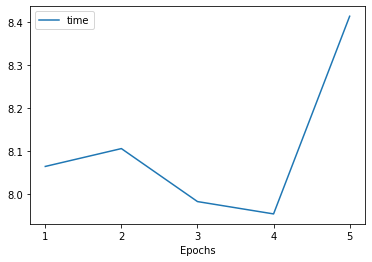

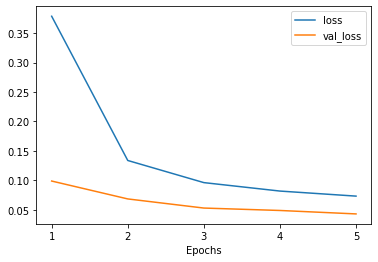

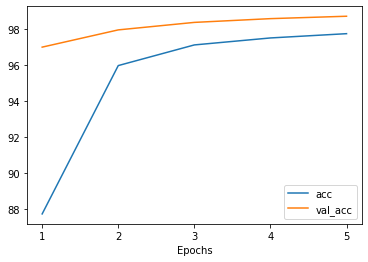

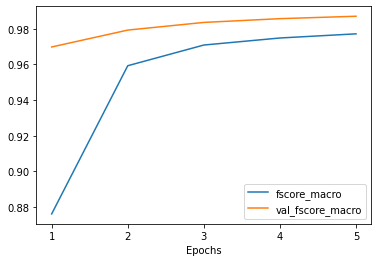

In [8]:
_ = plot_history(history)

It is also possible to restrict the metrics shown and to customize the plots by using custom labels and titles.

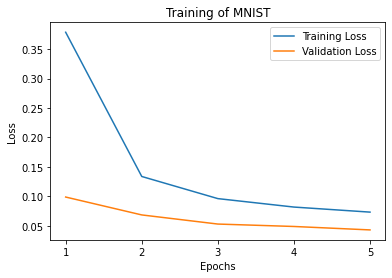

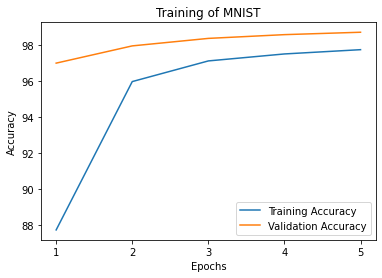

In [9]:
_ = plot_history(
    history,
    metrics=['loss', 'acc'],
    labels=['Loss', 'Accuracy'],
    titles='Training of MNIST',
)

## Initilalizing Your Optimizer and Loss Function Yourself

Instead of using magic strings for the optimizer and the loss function, it's quite easy to initialize your own and pass them to Poutyne.

In [10]:
# Instantiating our network
network = create_network()

# Instantiating our loss function and optimizer
own_optimizer = optim.SGD(network.parameters(), lr=learning_rate)
own_loss_function = nn.CrossEntropyLoss()

# Poutyne Model on GPU
model = Model(
    network,
    own_optimizer,
    own_loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 7.01s loss: 0.378740 acc: 87.750000 val_loss: 0.091613 val_acc: 97.275000
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.52s loss: 0.131763 acc: 95.912500 val_loss: 0.060723 val_acc: 98.233333
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.38s loss: 0.099851 acc: 96.922917 val_loss: 0.053079 val_acc: 98.525000
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.53s loss: 0.088178 acc: 97.235417 val_loss: 0.050858 val_acc: 98.541667
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.58s loss: 0.075830 acc: 97.645833 val_loss: 0.042662 val_acc: 98.766667
Test steps: 313 0.84s test_loss: 0.030614 test_acc: 98.950000                                                   


## Using Your Own Metric

Poutyne offers [a few metrics out-of-the-box](https://poutyne.org/metrics.html#object-oriented-api) and also supports metrics from [TorchMetrics](https://torchmetrics.readthedocs.io/), a library implementing many known metrics in PyTorch. See the [TorchMetrics documentation](https://torchmetrics.readthedocs.io/en/latest/references/modules.html) for available TorchMetrics metrics.

If metrics available in Poutyne and TorchMetrics do not suit your needs, you can define your own metric. Poutyne offers two interfaces for metrics. The first interface is the same as PyTorch loss functions: `metric(y_pred, y_true)`. When using that interface, the metric is assumed to be decomposable and is averaged for the whole epoch.

The second interface is defined by the [`Metric` class](https://poutyne.org/metrics.html#interface). As documented in the class, it provides methods for updating and computing the metric. This interface is compatible with [TorchMetrics](https://torchmetrics.readthedocs.io/).

In the code below, we demonstrate the usage of the two interfaces by implementing the accuracy in the two ways. The Metric interface is a bit more complex to use but also offers more flexibility.

In [11]:
# Creating a metric using the PyTorch loss interface.
def my_accuracy_func(y_pred, y_true):
    y_pred = y_pred.argmax(1)
    acc_pred = (y_pred == y_true).float().mean()
    return acc_pred * 100


# Creating a metric using the Metric interface.
class MyAccuracyMetric(Metric):
    def __init__(self):
        super().__init__()
        self.reset()

    def _compute_stats(self, y_pred, y_true):
        """
        Compute the number of true positives and the total number of elements
        of a given batch.
        """
        y_pred = y_pred.argmax(1)
        num_true_positives = (y_pred == y_true).long().sum().item()
        total_exemples = y_true.numel()
        return num_true_positives, total_exemples
    
    def _compute_accuracy_from_stats(self, num_true_positives, total_exemples):
        """
        Compute the accuracy given by the statistics computed in _compute_stats().
        """
        return num_true_positives / total_exemples * 100
    
    def _update(self, y_pred, y_true):
        """
        Increment the running number of true positives and number of elements.
        """
        num_true_positives, total_exemples = self._compute_stats(y_pred, y_true)
        self.num_true_positives += num_true_positives
        self.total_exemples += total_exemples
        return num_true_positives, total_exemples
        
    def forward(self, y_pred, y_true):
        """
        When using the metric as a batch metric, this is called. If the metric is only
        used as an epoch metric, there is no need to implement this.
        """
        num_true_positives, total_exemples = self._update(y_pred, y_true)
        return self._compute_accuracy_from_stats(num_true_positives, total_exemples)
    
    def update(self, y_pred, y_true):
        """
        When using the metric as an epoch metric, this is called. If the metric is only
        used as a batch metric, there is no need to implement this.
        """
        self._update(y_pred, y_true)

    def compute(self):
        """
        This is called at the end to get the value for the whole epoch.
        """
        return self._compute_accuracy_from_stats(self.num_true_positives, self.total_exemples)

    def reset(self) -> None:
        """
        Reset the statistics for another epoch.
        """
        self.num_true_positives = 0
        self.total_exemples = 0

In [12]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=[my_accuracy_func, MyAccuracyMetric()],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.74s loss: 0.383959 my_accuracy_func: 87.666667 my_accuracy_metric: 87.666667 val_loss: 0.090163 val_my_accuracy_func: 97.383333 val_my_accuracy_metric: 97.383333
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.66s loss: 0.128223 my_accuracy_func: 96.100000 my_accuracy_metric: 96.100000 val_loss: 0.066320 val_my_accuracy_func: 98.091667 val_my_accuracy_metric: 98.091667
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.70s loss: 0.099619 my_accuracy_func: 97.010417 my_accuracy_metric: 97.010417 val_loss: 0.057889 val_my_accuracy_func: 98.208333 val_my_accuracy_metric: 98.208333
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.63s loss: 0.083622 my_accuracy_func: 97.460417 my_accuracy_metric: 97.460417 val_loss: 0.050346 val_my_accuracy_func: 98.366667 val_my_accuracy_metric: 98.366667
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.92s loss: 0.076653 my_accuracy_func: 97.685417 my_accuracy_metric: 97.685417 val_loss: 0.059265 val_my_accuracy_func: 98.2

Furthermore, you could also use the [`SKLearnMetrics`](https://poutyne.org/metrics.html#poutyne.SKLearnMetrics) wrapper to wrap a Scikit-learn metric as an epoch metric. Below, we show how to compute the AUC ROC using the [`SKLearnMetrics`](https://poutyne.org/metrics.html#poutyne.SKLearnMetrics) class.

In [13]:
def softmax(x, axis=1):
    """
    Compute softmax function.
    """
    e_x = np.exp(x - x.max(axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def roc_auc(y_true, y_pred, **kwargs):
    """
    Since the `roc_auc_score` from Scikit-learn requires normalized probabilities,
    we use the softmax function on the predictions.
    """
    y_pred = softmax(y_pred)
    return roc_auc_score(y_true, y_pred, **kwargs)


# kwargs are keyword arguments we wish to pass to roc_auc.
roc_epoch_metric = SKLearnMetrics(roc_auc, kwargs=dict(multi_class='ovr', average='macro'))

In [14]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1', roc_epoch_metric],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1, test_roc) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.23s loss: 0.368582 acc: 88.110417 fscore_macro: 0.879912 roc_auc: 0.991401 val_loss: 0.106674 val_acc: 96.800000 val_fscore_macro: 0.967872 val_roc_auc: 0.999144
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.68s loss: 0.126682 acc: 96.135417 fscore_macro: 0.961056 roc_auc: 0.998664 val_loss: 0.061894 val_acc: 98.258333 val_fscore_macro: 0.982487 val_roc_auc: 0.999681
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.72s loss: 0.098693 acc: 97.008333 fscore_macro: 0.969876 roc_auc: 0.999182 val_loss: 0.053538 val_acc: 98.400000 val_fscore_macro: 0.983909 val_roc_auc: 0.999758
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.53s loss: 0.084671 acc: 97.391667 fscore_macro: 0.973760 roc_auc: 0.999401 val_loss: 0.050164 val_acc: 98.541667 val_fscore_macro: 0.985300 val_roc_auc: 0.999795
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.20s loss: 0.071751 acc: 97.822917 fscore_macro: 0.978080 roc_auc: 0.999565 val_loss: 0.045306 val_acc: 98.616667 val_fscor

## Bypassing PyTorch DataLoaders

Above, we defined DataLoaders for our datasets. However, with Poutyne, it is not strictly necessary since it provides the [`fit_dataset`](https://poutyne.org/model.html#poutyne.Model.fit_dataset) and [`evaluate_dataset`](https://poutyne.org/model.html#poutyne.Model.evaluate_dataset) methods to which you can pass the necessary parameters such as the batch size. Under the hood, Poutyne initializes the DataLoaders for you.

In [15]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_dataset(
    train_dataset,
    valid_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    num_workers=2,
)

# Test
test_loss, test_acc = model.evaluate_dataset(
    test_dataset,
    batch_size=batch_size,
    num_workers=2,
)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.40s loss: 0.376303 acc: 87.952083 val_loss: 0.084193 val_acc: 97.575000
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.70s loss: 0.129315 acc: 96.097917 val_loss: 0.074739 val_acc: 97.750000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.64s loss: 0.102616 acc: 96.868750 val_loss: 0.056323 val_acc: 98.491667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.48s loss: 0.087765 acc: 97.391667 val_loss: 0.052291 val_acc: 98.533333
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.55s loss: 0.075437 acc: 97.672917 val_loss: 0.046242 val_acc: 98.791667
Test steps: 313 0.85s test_loss: 0.033271 test_acc: 98.920000                                                   


## Using Callbacks

One nice feature of Poutyne is [callbacks](https://poutyne.org/callbacks.html). Callbacks allow doing actions during the training of the neural network. In the following example, we use three callbacks. The first that saves the latest weights in a file to be able to continue the optimization at the end of training if more epochs are needed. The second that saves the best weights according to the performance on the validation dataset. The last that saves the displayed logs into a TSV file.

In [16]:
# Saves everything into saves/convnet_mnist
save_path = "saves/convnet_mnist"
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [17]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.80s loss: 0.379219 acc: 87.589583 val_loss: 0.095315 val_acc: 97.183333
Epoch 1: val_acc improved from -inf to 97.18333, saving file to saves/convnet_mnist/best_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.60s loss: 0.127790 acc: 96.127083 val_loss: 0.069420 val_acc: 97.966667
Epoch 2: val_acc improved from 97.18333 to 97.96667, saving file to saves/convnet_mnist/best_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.76s loss: 0.100507 acc: 96.997917 val_loss: 0.052325 val_acc: 98.375000
Epoch 3: val_acc improved from 97.96667 to 98.37500, saving file to saves/convnet_mnist/best_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.53s loss: 0.084314 acc: 97.416667 val_loss: 0.049132 val_acc: 98.633333
Epoch 4: val_acc improved from 98.37500 to 98.63333, saving file to saves/convnet_mnist/best_epoch_4.ckpt
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.49s loss: 0.073190 acc: 97.775000 val_loss: 0.044298 val_acc: 

## Making Your Own Callback

While Poutyne provides a great number of [predefined callbacks](https://poutyne.org/callbacks.html), it is sometimes useful to make your own callback.

In the following example, we want to see the effect of temperature on the optimization of our neural network. To do so, we either increase or decrease the temperature during the optimization. As one can see in the result, temperature either as no effect or has a detrimental effect on the performance of the neural network. This is so because the temperature has for effect to artificially changing the learning rates. Since we have found the right learning rate, increasing or decreasing, it shows no improvement on the results.

In [18]:
class CrossEntropyLossWithTemperature(nn.Module):
    """
    This loss module is the cross-entropy loss function
    with temperature. It divides the logits by a temperature
    value before computing the cross-entropy loss.

    Args:
        initial_temperature (float): The initial value of the temperature.
    """

    def __init__(self, initial_temperature):
        super().__init__()
        self.temperature = initial_temperature
        self.celoss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        y_pred = y_pred / self.temperature
        return self.celoss(y_pred, y_true)

In [19]:
class TemperatureCallback(Callback):
    """
    This callback multiply the loss temperature with a decay before
    each batch.

    Args:
        celoss_with_temp (CrossEntropyLossWithTemperature): the loss module.
        decay (float): The value of the temperature decay.
    """

    def __init__(self, celoss_with_temp, decay):
        super().__init__()
        self.celoss_with_temp = celoss_with_temp
        self.decay = decay

    def on_train_batch_begin(self, batch, logs):
        self.celoss_with_temp.temperature *= self.decay

So our loss function will be the cross-entropy with temperature with an initial temperature of `0.1` and a temperature decay of `1.0008`.

In [20]:
custom_loss_function = CrossEntropyLossWithTemperature(0.1)
callbacks = [TemperatureCallback(custom_loss_function, 1.0008)]

Now let's test our training loop for one epoch using the accuracy as the batch metric.

In [21]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    custom_loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.74s loss: 0.470274 acc: 85.037500 val_loss: 0.089246 val_acc: 97.325000
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.62s loss: 0.136065 acc: 96.068750 val_loss: 0.058898 val_acc: 98.283333
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.82s loss: 0.111425 acc: 96.741667 val_loss: 0.057114 val_acc: 98.291667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.71s loss: 0.109230 acc: 96.927083 val_loss: 0.063533 val_acc: 98.183333
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.82s loss: 0.123607 acc: 96.660417 val_loss: 0.074446 val_acc: 98.025000
Test steps: 313 0.87s test_loss: 0.062896 test_acc: 98.290000                                                   


## Using ModelBundle

Most of the time, when using Poutyne (or even PyTorch in general), we will find ourselves in an iterative model hyperparameters finetuning loop. For efficient model search, we will usually wish to save our best performing models, their training and testing statistics and even sometimes wish to retrain an already trained model for further tuning. All of the above can be easily implemented with the flexibility of Poutyne Callbacks, but having to define and initialize each and every Callback object we wish for our model quickly feels cumbersome.

This is why Poutyne provides a [ModelBundle class](https://poutyne.org/experiment.html#poutyne.ModelBundle), which aims specifically at enabling quick model iteration search, while not sacrificing the quality of a single experiment - statistics logging, best models saving, etc. ModelBundle is actually a simple wrapper between a PyTorch network and Poutyne's core Callback objects for logging and saving. Given a working directory where to output the various logging files and a PyTorch network, the ModelBundle class reduces the whole training loop to a single line.

The following code uses [Poutyne's ModelBundle class](https://poutyne.org/experiment.html#poutyne.ModelBundle) to train a network for 5 epochs. The code is quite simpler than the code in the Poutyne Callbacks section while doing more (only a few lines). Once trained for 5 epochs, it is then possible to resume the optimization at the 5th epoch for 5 more epochs until the 10th epoch using the same function.

In [22]:
def train_model_bundle(network, name, epochs=5):
    """
    This function creates a Poutyne ModelBundle, trains the input module
    on the train loader and then tests its performance on the test loader.
    All training and testing statistics are saved, as well as best model
    checkpoints.

    Args:
        network (torch.nn.Module): The neural network to train.
        working_directory (str): The directory where to output files to save.
        epochs (int): The number of epochs. (Default: 5)
    """
    # Everything is going to be saved in ./saves/{name}.
    save_path = os.path.join('saves', name)

    # Poutyne ModelBundle
    model_bundle = ModelBundle.from_network(
        save_path,
        network,
        optimizer=optimizer,
        task='classif',
        device=device,
    )

    # Train
    model_bundle.train(train_loader, valid_loader, epochs=epochs)

    # Test
    model_bundle.test(test_loader)

Let's first remove the output directory if it exists so that we start training from scratch.

In [23]:
shutil.rmtree('saves/convnet_mnist_model_bundle', ignore_errors=True)

Let's train for 5 epochs.

In [24]:
network = create_network()
train_model_bundle(network, 'convnet_mnist_model_bundle', epochs=5)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.51s loss: 0.366255 acc: 88.012500 fscore_macro: 0.879123 val_loss: 0.077714 val_acc: 97.741667 val_fscore_macro: 0.977352
Epoch 1: val_acc improved from -inf to 97.74167, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.45s loss: 0.127324 acc: 96.200000 fscore_macro: 0.961720 val_loss: 0.060472 val_acc: 98.208333 val_fscore_macro: 0.982050
Epoch 2: val_acc improved from 97.74167 to 98.20833, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.12s loss: 0.098540 acc: 97.052083 fscore_macro: 0.970294 val_loss: 0.053993 val_acc: 98.358333 val_fscore_macro: 0.983539
Epoch 3: val_acc improved from 98.20833 to 98.35833, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.03s loss: 0.081231 acc: 97.552083 fscore_macro: 0.975337 val_loss: 0.044749 val

Notice how setting `task='classif'` when instantiating `ModelBundle` adds for use our loss function, the batch metric accuracy, the epoch metric F1 and set up callbacks that use them. If you wish, you still can use your own loss function and metrics instead of passing this argument.

We have trained for 5 epochs, let's now resume training for another 5 epochs for a total of 10 epochs. Notice that we reinstantiate the network. ModelBundle will load back the weights for us and resume training.

In [25]:
network = create_network()
train_model_bundle(network, 'convnet_mnist_model_bundle', epochs=10)

Loading weights from saves/convnet_mnist_model_bundle/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves/convnet_mnist_model_bundle/checkpoint.optim and starting at epoch 6.
Loading random states from saves/convnet_mnist_model_bundle/checkpoint.randomstate and starting at epoch 6.
Epoch:  6/10 Train steps: 1500 Val steps: 375 8.16s loss: 0.065763 acc: 98.022917 fscore_macro: 0.980102 val_loss: 0.037387 val_acc: 98.941667 val_fscore_macro: 0.989383
Epoch 6: val_acc improved from 98.82500 to 98.94167, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_6.ckpt
Epoch:  7/10 Train steps: 1500 Val steps: 375 8.41s loss: 0.062799 acc: 98.081250 fscore_macro: 0.980670 val_loss: 0.036032 val_acc: 98.958333 val_fscore_macro: 0.989533
Epoch 7: val_acc improved from 98.94167 to 98.95833, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_7.ckpt
Epoch:  8/10 Train steps: 1500 Val steps: 375 8.29s loss: 0.059569 acc: 98.181250 fscore_macro: 0.98167

## Coloring

Also, Poutyne use by default a coloring template of the training step when the package `colorama` is installed.
One could either remove the coloring (`progress_options=dict(coloring=False)`) or set a different coloring template using the fields:
`text_color`, `ratio_color`, `metric_value_color`, `time_color` and `progress_bar_color`.
If a field is not specified, the default color will be used.
[See available colors in colorama's source code](https://github.com/tartley/colorama/blob/9946cfb/colorama/ansi.py#L49).

Here an example where we set the `text_color` to RED and the `progress_bar_color` to LIGHTGREEN_EX.

In [26]:
progress_options = dict(coloring=dict(text_color="RED", progress_bar_color="LIGHTGREEN_EX"))

In [27]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(
    train_loader,
    valid_loader,
    epochs=num_epochs,
    progress_options=progress_options,
)

# Test
test_loss, test_acc = model.evaluate_generator(
    test_loader,
    progress_options=progress_options,
)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.54s loss: 0.370519 acc: 88.125000 val_loss: 0.089264 val_acc: 97.366667
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.41s loss: 0.129163 acc: 96.087500 val_loss: 0.065395 val_acc: 98.075000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.27s loss: 0.098094 acc: 97.097917 val_loss: 0.058571 val_acc: 98.341667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.58s loss: 0.085683 acc: 97.452083 val_loss: 0.049200 val_acc: 98.658333
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.62s loss: 0.074192 acc: 97.768750 val_loss: 0.046122 val_acc: 98.675000
Test steps: 313 0.84s test_loss: 0.032857 test_acc: 98.890000                                                   


## Custom Metric Names

It's also possible to name the metric using a tuple format `(<metric name>, metric)`. That way, it's possible to use multiple times the same metric type (i.e. having micro and macro F1-score).

In [28]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=[("My accuracy name", 'accuracy')],
    epoch_metrics=[("My f1 name", 'f1')],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 7.92s loss: 0.355768 My accuracy name: 88.662500 My f1 name: 0.885614 val_loss: 0.090990 val_My accuracy name: 97.208333 val_My f1 name: 0.971917
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.21s loss: 0.123316 My accuracy name: 96.358333 My f1 name: 0.963292 val_loss: 0.064429 val_My accuracy name: 98.050000 val_My f1 name: 0.980377
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.02s loss: 0.098334 My accuracy name: 97.056250 My f1 name: 0.970343 val_loss: 0.053564 val_My accuracy name: 98.408333 val_My f1 name: 0.983988
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.30s loss: 0.084703 My accuracy name: 97.435417 My f1 name: 0.974177 val_loss: 0.049505 val_My accuracy name: 98.591667 val_My f1 name: 0.985820
Epoch: 5/5 Train steps: 1500 Val steps: 375 7.98s loss: 0.073237 My accuracy name: 97.772917 My f1 name: 0.977587 val_loss: 0.044072 val_My accuracy name: 98.725000 val_My f1 name: 0.987223
Test steps: 313 0.96s test_loss: 0.029208 test_My 

## Multi-GPUs

Finally, it's also possible to use multi-GPUs for your training either by specifying a list of devices or using the arg `"all"` to take them all.

> Obviously, you need more than one GPUs for that option.

In our case here, multi-gpus takes more time because the task is not big enough to profit from multi-gpus.

In [29]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device="all",
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

Epoch: 1/5 Train steps: 1500 Val steps: 375 17.00s loss: 0.386154 acc: 87.333333 val_loss: 0.092202 val_acc: 97.191667
Epoch: 2/5 Train steps: 1500 Val steps: 375 14.81s loss: 0.125460 acc: 96.172917 val_loss: 0.062402 val_acc: 98.116667
Epoch: 3/5 Train steps: 1500 Val steps: 375 14.63s loss: 0.097736 acc: 96.977083 val_loss: 0.056723 val_acc: 98.383333
Epoch: 4/5 Train steps: 1500 Val steps: 375 14.74s loss: 0.083548 acc: 97.508333 val_loss: 0.045911 val_acc: 98.725000
Epoch: 5/5 Train steps: 1500 Val steps: 375 14.80s loss: 0.075282 acc: 97.731250 val_loss: 0.045916 val_acc: 98.650000


[{'epoch': 1,
  'time': 17.00380860781297,
  'loss': 0.3861539592298989,
  'acc': 87.33333333333333,
  'val_loss': 0.09220197118197879,
  'val_acc': 97.19166666666666},
 {'epoch': 2,
  'time': 14.805061359889805,
  'loss': 0.12545990319394817,
  'acc': 96.17291666666667,
  'val_loss': 0.06240178443475937,
  'val_acc': 98.11666666666666},
 {'epoch': 3,
  'time': 14.63108725193888,
  'loss': 0.09773606853660506,
  'acc': 96.97708333333334,
  'val_loss': 0.0567228243414623,
  'val_acc': 98.38333333333334},
 {'epoch': 4,
  'time': 14.74231273215264,
  'loss': 0.08354751471034251,
  'acc': 97.50833333333334,
  'val_loss': 0.04591141694528051,
  'val_acc': 98.725},
 {'epoch': 5,
  'time': 14.79857192421332,
  'loss': 0.0752823881568232,
  'acc': 97.73125,
  'val_loss': 0.04591631960236312,
  'val_acc': 98.65}]